In [23]:
from cmethods import CMethods

In [2]:
import xarray as xr

In [3]:
obs = xr.open_dataset("examples/input_data/observations.nc")["tas"]
simh = xr.open_dataset("examples/input_data/control.nc")["tas"]
simp = xr.open_dataset("examples/input_data/scenario.nc")["tas"]

In [16]:
def apply_ufunc(method, obs, simh, simp, **kwargs):
    result = xr.apply_ufunc(
        cm()._CMethods__delta_method,
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is different
        # than 'time' coord on training dataset.
        simp.rename({"time": "t2"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid cell
        # independently
        input_core_dims=[["time"], ["time"], ["t2"]],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["t2"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"t2": "time"})

    # ufunc will put the core dimension to the end (time), so want to preserve original
    # order where time is commonly first.
    return result.transpose(*obs.dims)

In [18]:
from typing import Tuple, List, Optional
import numpy as np

In [19]:
def get_datasets(
        kind: str,
    ) -> Tuple[xr.Dataset, xr.Dataset, xr.Dataset, xr.Dataset]:
    historical_time = xr.cftime_range(
        "1971-01-01", "2000-12-31", freq="D", calendar="noleap"
    )
    future_time = xr.cftime_range(
        "2001-01-01", "2030-12-31", freq="D", calendar="noleap"
    )
    latitudes = np.arange(23, 27, 1)

    def get_hist_temp_for_lat(lat: int) -> List[float]:
        """Returns a fake interval time series by latitude value"""
        return 273.15 - (
            lat * np.cos(2 * np.pi * historical_time.dayofyear / 365)
            + 2 * np.random.random_sample((historical_time.size,))
            + 273.15
            + 0.1 * (historical_time - historical_time[0]).days / 365
        )

    def get_fake_hist_precipitation_data() -> List[float]:
        """Returns ratio based fake time series"""
        pr = (
            np.cos(2 * np.pi * historical_time.dayofyear / 365)
            * np.cos(2 * np.pi * historical_time.dayofyear / 365)
            * np.random.random_sample((historical_time.size,))
        )

        pr *= 0.0004 / pr.max()  # scaling
        years = 30
        days_without_rain_per_year = 239

        c = days_without_rain_per_year * years  # avoid rain every day
        pr.ravel()[np.random.choice(pr.size, c, replace=False)] = 0
        return pr

    def get_dataset(data, time, kind: str) -> xr.Dataset:
        """Returns a data set by data and time"""
        return (
            xr.DataArray(
                data,
                dims=("lon", "lat", "time"),
                coords={"time": time, "lat": latitudes, "lon": [0, 1, 3]},
            )
            .transpose("time", "lat", "lon")
            .to_dataset(name=kind)
        )

    if kind == "+":
        some_data = [get_hist_temp_for_lat(val) for val in latitudes]
        data = np.array(
            [
                np.array(some_data),
                np.array(some_data) + 0.5,
                np.array(some_data) + 1,
            ]
        )
        obsh = get_dataset(data, historical_time, kind=kind)
        obsp = get_dataset(data + 1, historical_time, kind=kind)
        simh = get_dataset(data - 2, historical_time, kind=kind)
        simp = get_dataset(data - 1, future_time, kind=kind)

    else:  # precipitation
        some_data = [get_fake_hist_precipitation_data() for _ in latitudes]
        data = np.array(
            [some_data, np.array(some_data) + np.random.rand(), np.array(some_data)]
        )
        obsh = get_dataset(data, historical_time, kind=kind)
        obsp = get_dataset(data * 1.02, historical_time, kind=kind)
        simh = get_dataset(data * 0.98, historical_time, kind=kind)
        simp = get_dataset(data * 0.09, future_time, kind=kind)

    return obsh, obsp, simh, simp

In [20]:
obsh_add, obsp_add, simh_add, simp_add = get_datasets(kind="+")
obsh_mult, obsp_mult, simh_mult, simp_mult = get_datasets(kind="*")

data = {
    "+": {
        "obsh": obsh_add["+"],
        "obsp": obsp_add["+"],
        "simh": simh_add["+"],
        "simp": simp_add["+"],
    },
    "*": {
        "obsh": obsh_mult["*"],
        "obsp": obsp_mult["*"],
        "simh": simh_mult["*"],
        "simp": simp_mult["*"],
    },
}

In [33]:
cm = CMethods()

from cmethods.types import NPData, XRData
from cmethods.utils import get_cdf, nan_or_equal

In [34]:
def get_dqm_kwargs(
    obs: XRData, simh: XRData, simp: XRData, n_quantiles: int
) -> dict | NPData:
    if not isinstance(n_quantiles, int):
        raise TypeError("'n_quantiles' must be type int")
    kwargs: dict = {}
    kwargs["global_max"] = max(obs.max(skipna=True), simh.max(skipna=True))
    kwargs["global_min"] = min(obs.min(skipna=True), simh.min(skipna=True))

    if nan_or_equal(value1=kwargs["global_max"], value2=kwargs["global_min"]):
        return simp

    kwargs["wide"] = abs(kwargs["global_max"] - kwargs["global_min"]) / n_quantiles
    kwargs["xbins"] = np.arange(
        kwargs["global_min"],
        kwargs["global_max"] + kwargs["wide"],
        kwargs["wide"],
    )

    kwargs["cdf_obs"] = get_cdf(obs, kwargs["xbins"])
    kwargs["cdf_simh"] = get_cdf(simh, kwargs["xbins"])
    return kwargs

In [43]:
# Assuming obs, simh, simp are your xarray datasets
# Define the function to be applied along the spatial dimensions
def apply_dqm_kwargs(lat, lon, n_quantiles):
    print(lon)
    return get_dqm_kwargs(obs.sel(lat=lat, lon=lon),
                            simh.sel(lat=lat, lon=lon),
                            simp.sel(lat=lat, lon=lon),
                            n_quantiles)

In [44]:
lat_coords = obs['lat'].values
lon_coords = obs['lon'].values
result = xr.apply_ufunc(
    apply_dqm_kwargs, lat_coords, lon_coords,
    input_core_dims=[[], []],
    output_core_dims=[[], []],
    vectorize=True,
    dask='parallelized',  # Use 'allowed' for dask arrays
    output_dtypes=[object],
    kwargs={'n_quantiles': 100}
)

[0 1]


In [45]:
result

{'global_max': <xarray.DataArray 'tas' ()>
 array(26.83185172),
 'global_min': <xarray.DataArray 'tas' ()>
 array(-32.83435462),
 'wide': <xarray.DataArray 'tas' ()>
 array(0.59666206),
 'xbins': array([-3.28343546e+01, -3.22376926e+01, -3.16410305e+01, -3.10443684e+01,
        -3.04477064e+01, -2.98510443e+01, -2.92543822e+01, -2.86577202e+01,
        -2.80610581e+01, -2.74643961e+01, -2.68677340e+01, -2.62710719e+01,
        -2.56744099e+01, -2.50777478e+01, -2.44810857e+01, -2.38844237e+01,
        -2.32877616e+01, -2.26910995e+01, -2.20944375e+01, -2.14977754e+01,
        -2.09011134e+01, -2.03044513e+01, -1.97077892e+01, -1.91111272e+01,
        -1.85144651e+01, -1.79178030e+01, -1.73211410e+01, -1.67244789e+01,
        -1.61278168e+01, -1.55311548e+01, -1.49344927e+01, -1.43378307e+01,
        -1.37411686e+01, -1.31445065e+01, -1.25478445e+01, -1.19511824e+01,
        -1.13545203e+01, -1.07578583e+01, -1.01611962e+01, -9.56453415e+00,
        -8.96787209e+00, -8.37121002e+00, -7.

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
from cmethods.static import DISTRIBUTION_METHODS

In [13]:
for kind in ("+", "*"):
    for method in DISTRIBUTION_METHODS:
        print(kind, method, sep=" ")
        kwargs: dict = {}
        if method == "detrended_quantile_mapping":
            kwargs = {"group": "time.month"}

        result = cm.adjust(
            method=method,
            obs=data[kind]["obsh"],
            simh=data[kind]["simh"],
            simp=data[kind]["simp"],
            n_quantiles=25,
            kind=kind, **kwargs
        )
        #assert isinstance(result, XRData_t)
        for lat in range(len(data[kind]["obsh"].lat)):
            for lon in range(len(data[kind]["obsh"].lon)):
                assert mean_squared_error(
                    result[:, lat, lon],
                    data[kind]["obsp"][:, lat, lon],
                    squared=False,
                ) < mean_squared_error(
                    data[kind]["simp"][:, lat, lon],
                    data[kind]["obsp"][:, lat, lon],
                    squared=False,
                )

+ quantile_mapping
+ detrended_quantile_mapping


ValueError: Unsupported key-type <class 'tuple'>

In [49]:
kind = "+"

In [62]:
data[kind]["obsp"][:,0,0]

<xarray.DataArray '+' (time: 10950)>
array([-22.5081611 , -23.19907675, -23.38420835, ..., -26.29696524,
       -26.21782804, -25.96699298])
Coordinates:
  * time     (time) object 1971-01-01 00:00:00 ... 2000-12-31 00:00:00
    lat      int64 23
    lon      int64 0

time.month


In [141]:
def apply_ufunc(method: str, obs, simh, simp, **kwargs: dict
    ) :

    result = xr.apply_ufunc(
        cm.get_function(method),
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is different
        # than 'time' coord on training dataset.
        simp.rename({"time": "t2"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid cell
        # independently
        input_core_dims=[["time"], ["time"], ["t2"]],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["t2"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"t2": "time"})

    # ufunc will put the core dimension to the end (time), so want to preserve original
    # order where time is commonly first.
    return result.transpose(*obs.dims)

obs = data[kind]["obsh"]
simh = data[kind]["simh"]
simp = data[kind]["simp"]

group: str = "time.month"
method="linear_scaling"
obs_g = list(obs.groupby(group))
simh_g = list(simh.groupby(group))
simp_g = list(simp.groupby(group))

result = None
for index in range(len(list(obs_g))):
    obs_gds = obs_g[index][1]
    
    simh_gds = simh_g[index][1]
    simp_gds = simp_g[index][1]

    monthly_result = apply_ufunc(
        method, obs_gds, simh_gds, simp_gds, kind="+"
    )
    if result is None:
        result = monthly_result
    else:
        result = xr.merge([result, monthly_result])
result

<xarray.Dataset>
Dimensions:  (lat: 4, lon: 3, time: 10950)
Coordinates:
  * lat      (lat) int64 23 24 25 26
  * lon      (lon) int64 0 1 3
  * time     (time) object 2001-01-01 00:00:00 ... 2030-12-31 00:00:00
Data variables:
    +        (time, lat, lon) float64 -22.51 -22.01 -21.51 ... -29.14 -28.64

In [144]:
for lat in range(len(data[kind]["obsh"].lat)):
    for lon in range(len(data[kind]["obsh"].lon)):
        new = mean_squared_error(
            result["+"][:, lat, lon], data[kind]["obsp"][:, lat, lon], squared=False
        ) 
        old = mean_squared_error(
            data[kind]["simp"][:, lat, lon],
            data[kind]["obsp"][:, lat, lon],
            squared=False,
        )

        assert new < old, f"{new}, {old} {lat} {lon}" 

In [112]:
import matplotlib.pyplot as plt

In [111]:
mean_squared_error(data[kind]["obsp"][:,0,0], result[:,0,0],squared=False)

23.129143207023734

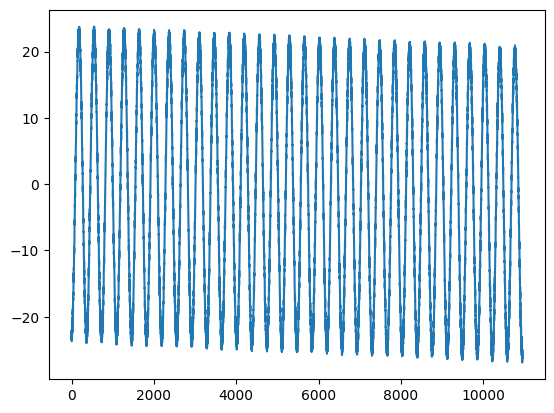

In [116]:
plt.plot(data[kind]["obsp"][:,0,0])

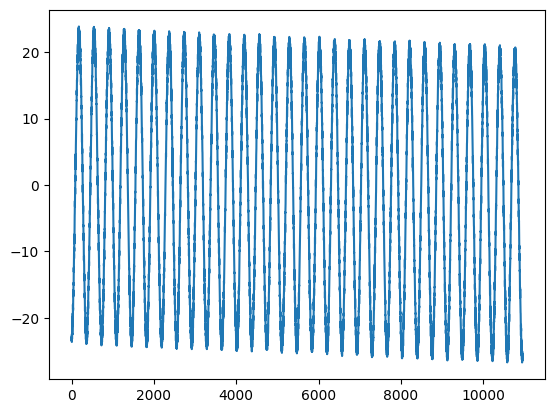

In [130]:
plt.plot(result["tas"][:,0,0])